# Persistent Homology Analysis of Cell Morphology

Pipeline from the paper [Persistence diagrams as morphological signatures of cells: A method to measure and compare cells within a population](https://files.yossi.eu/manuscripts/2310.20644.pdf) by Yossi Bokor Bleile, Pooja Yadav, Patrice Koehl, and Florian Rehfeldt.

The following packages need to be installed: 
- [Correa](https://correa.yossi.eu)
- plotly
- pandas
- sklearn
- numpy
- matplotlib
- tifffile

## Overview

We begin the analysis by obtaining a persistence diagram for each cell in the population, as a summary of the morphology of the cell. This notebook contains three main analysis sections:

1. **X1 Dataset**: Analysis of hMSC cells
2. **Y1 Dataset**: Analysis of HeLa cells  
3. **X1Y1 Combined Dataset**: Comparative analysis of both cell types together


## Import modules

In [34]:
import os
import correa
import pandas
import tifffile
import plotly.express as px
import plotly.figure_factory as ff		
import plotly.io as pio
import plotly.graph_objects as go
from sklearn import manifold, cluster, decomposition, metrics, preprocessing
import numpy
import scipy.cluster
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import ClusterWarning
from matplotlib import pyplot as plt
import matplotlib
from scipy.spatial.distance import squareform
from warnings import simplefilter
simplefilter("ignore", ClusterWarning)

pio.renderers.default = "browser" #set the renderer to browser

## Custom functions for the analysis

We next define some custom functions to make creating the dendrograms easier.


In [2]:
#set colours
def rgb_to_hex(r, g, b):
    return '#{:02x}{:02x}{:02x}'.format(r, g, b)
hex_list = []
for c in px.colors.qualitative.Set1:
	hex_list.append(rgb_to_hex(int(c.replace("rgb(","").replace(")","").split(",")[0]),int(c.replace("rgb(","").replace(")","").split(",")[1]), int(c.replace("rgb(","").replace(")","").split(",")[2])))
 

def generate_rand_index(cluster_df : pandas.DataFrame, to_compare : list):
	r_ind = pandas.DataFrame(columns=to_compare, index=to_compare)
	for i in to_compare:
		for j in to_compare:
			r_ind[i].loc[j] = metrics.rand_score(cluster_df[i], cluster_df[j])
	return r_ind

def population_percentages(df : pandas.DataFrame, clustering : str):
	labels = [int(c) for c in df[clustering]]
	counts = [0 for i in range(max(labels)+1)]
	for l in labels:
		counts[l]+=1
	percentages = [c/len(labels) for c in counts]
	return percentages, counts

def analysis(dists : pandas.DataFrame, cluster_numbers : list,  name : str,  dir : str, group = False, exclude : list = [], colour_list=hex_list):
	#colour order is red, purple, blue, green
	if group == False:
		inds = dists.index
		dists = dists
		if len(exclude) != 0:
			inds = []
			for f in dists.index:
				if f not in exclude:
					inds.append(f)
			dists = dists[inds].loc[inds]
	else:
		inds = []
		for f in dists.index:
			if group in f and f not in exclude:
				inds.append(f)
		dists = dists[inds].loc[inds]
	df = pandas.DataFrame(index=inds)
	embed = manifold.MDS(3, dissimilarity='precomputed', random_state=1, normalized_stress="auto").fit_transform(dists.to_numpy())
	df["x"] = embed[:,0]
	df["y"] = embed[:,1]
	df["z"] = embed[:,2]
	silhouette_samples = []
	silhouette_score = []
	linkage_matrices = []
	avg = cluster.AgglomerativeClustering(distance_threshold=None, n_clusters=4, linkage="average")
	avg = avg.fit(dists.to_numpy())
	dflt = "#000000"
	D_leaf_colors = {dists.index[i]: colour_list[avg.labels_[i]] for i in range(len(avg.labels_))}
	#Average
	for link in ["average", "complete", "single", "ward"]:
		linkage = cluster.AgglomerativeClustering(distance_threshold=0, n_clusters=None, linkage=link)
		linkage = linkage.fit(dists.to_numpy())
		counts = numpy.zeros(linkage.children_.shape[0])
		n_samples = len(linkage.labels_)
		for i, merge in enumerate(linkage.children_):
			current_count = 0
			for child_idx in merge:
				if child_idx < n_samples:
					current_count += 1  # leaf node
				else:	
					current_count += counts[child_idx - n_samples]
			counts[i] = current_count
		linkage_matrix = numpy.column_stack([linkage.children_, linkage.distances_, counts]).astype(float)
		linkage_matrices.append(linkage_matrix)
		# notes:
		# * rows in Z correspond to "inverted U" links that connect clusters
		# * rows are ordered by increasing distance
		# * if the colors of the connected clusters match, use that color for link
		link_cols = {}
		for i, i12 in enumerate(linkage_matrix[:,:2].astype(int)):
			c1, c2 = (link_cols[x] if x > len(linkage_matrix) else D_leaf_colors[dists.index[x]] for x in i12)
			if c1 == c2:
				link_cols[i+1+len(linkage_matrix)] = c1
			else:
				if i12[0] < n_samples:
					link_cols[i+1+len(linkage_matrix)] = D_leaf_colors[dists.index[i12[0]]]
				elif i12[1] < n_samples:
					link_cols[i+1+len(linkage_matrix)] = D_leaf_colors[dists.index[i12[1]]]
				else:
					link_cols[i+1+len(linkage_matrix)] = dflt

	sse = []
	for link in ["average", "complete", "single", "ward"]:
		for k in cluster_numbers:
			linkage = cluster.AgglomerativeClustering(distance_threshold=None, n_clusters=k, linkage=link)
			linkage = linkage.fit(dists.to_numpy())
			labels = linkage.labels_
			labels = [str(c) for c in labels]
			df[link+str(k)] = labels
			sil_score = metrics.silhouette_score(dists, df[link+str(k)], metric="precomputed")
			silhouette_score.append(sil_score)
			sil_samps = metrics.silhouette_samples(dists, df[link+str(k)], metric="precomputed")
			silhouette_samples.append([sil_samps])
		
	df.to_csv(dir+"/"+name.replace(" ","_")+"_df.csv")
	rand_ind_tables_latex = []
	percentages_dict = {}
	for k in cluster_numbers:
		rand_ind_tables_latex.append(generate_rand_index(df, ["average"+str(k), "complete"+str(k), "single"+str(k),"ward"+str(k)]).to_latex())
		print("cluster sizes and percentages are:")
		percentages_dict["average{}".format(k)], counts = population_percentages(df, "average"+str(k))
		print("average{}".format(k), counts, percentages_dict["average{}".format(k)])
		percentages_dict["complete{}".format(k)], counts = population_percentages(df, "complete"+str(k))
		print("complete{}".format(k), counts, percentages_dict["complete{}".format(k)])
		percentages_dict["single{}".format(k)], counts = population_percentages(df, "single"+str(k))
		print("single{}".format(k), counts, percentages_dict["single{}".format(k)])
		percentages_dict["ward{}".format(k)], counts = population_percentages(df, "ward"+str(k))
		print("ward{}".format(k), counts, percentages_dict["ward{}".format(k)])
	return df, silhouette_score, silhouette_samples, rand_ind_tables_latex, percentages_dict, dists, linkage_matrices

def get_main_population(analysis, cluster : str, dists : pandas.DataFrame):
	main_id = analysis[4][cluster].index(max(analysis[4][cluster]))
	main_index= analysis[0].index[analysis[0][cluster] == str(main_id)]
	return dists[main_index].loc[main_index]

def purity(merges, clus : set, n_objs):
	dct = dict([(i, {i}) for i in range(n_objs)])
	for i, row in enumerate(merges, n_objs):
		dct[i] = dct[row[0]].union(dct[row[1]])
		del dct[row[0]]
		del dct[row[1]]
		for c in list(dct.values()):
			if clus.issubset(c):
				return c, (n_objs-len(c))/(n_objs-len(clus))

# X1 Dataset Analysis

The X1 dataset contains 140 hMSC (human mesenchymal stem cells) cells. We will:
1. Load the cell contours and nucleus centers
2. Compute persistence diagrams for each cell
3. Calculate Wasserstein distances between all pairs
4. Perform hierarchical clustering analysis

In [3]:
## X1 Dataset Setup

# Set dataset parameters for X1
dataset_X1 = "X1"
width_X1 = 1500  # Largest width of an image in the X1 dataset (FilamentSensor2 pads all images to same size)
height_X1 = 1692  # Largest height of an image in the X1 dataset
conversion_factor_X1 = 0.3155
# Get all cell files
files_X1 = os.listdir("../" + dataset_X1 + "/cell/raw_images")
cell_names_X1 = sorted([int(file[0:3]) for file in files_X1 if file.endswith('.tif')])
n_cells_X1 = len(cell_names_X1)
print(f"X1 dataset contains {n_cells_X1} cells")


X1 dataset contains 140 cells


## X1: Load Nucleus Centers

First, we will load the file containing the center of the nucleus for each cell.

Next, for each cell we will calculate the persistence diagram using a radial function based at the center of the nucleus. We need to translate the center of the nucleus into the same frame as the contour is in. This is due to the way FilamentSensor extracts the contour of each cell in a directory. The appropriate `height` and `width` values can be found in the [FilamentSensor2](https://filament-sensor.de/) log file.

In [4]:
centers_X1 = pandas.read_csv(f"{dataset_X1}_focal_points.csv", index_col="cell_name")
print(f"Loaded nucleus centers for {len(centers_X1)} cells")

Loaded nucleus centers for 140 cells


## X1: Compute Persistence Diagrams

Now we compute the persistence diagram for each cell using the radial function based at the nucleus center.


In [6]:
contours_X1 = []
for i in cell_names_X1:
	actin = tifffile.imread("../" + dataset_X1 + "/cell/raw_images/" + str("%03d" % i) + ".tif")
	height_diff = height_X1 - actin.shape[0]
	width_diff = width_X1 - actin.shape[1]
	
	# Calculate focal adhesion point with width and height diff added
	focal_point = [centers_X1.loc[i, "X"], centers_X1.loc[i, "Y"]]

	# Create polygon with focal point at nucleus center
	c_i = correa.create_polygon_focal_point(
		"../" + dataset_X1 + "/cell/contours/" + str("%03d" % i) + "_contour.csv", 
		focal_point, convert_to_microns_factor=conversion_factor_X1
	)
	c_i.persistence_diagram()
	contours_X1.append(c_i)
	
	if (i+1) % 20 == 0:
		print(f"Processed {i+1}/{n_cells_X1} cells")

print(f"Completed persistence diagrams for all {n_cells_X1} cells")

Number of points loaded: 2555
focal is (722.267, 812.922).
Number of points before cleaning: 2555

Initial number of points in polygon      : 2555
Number of points in polygon after cleanup: 1256

build the polygon with 1256 points
shifting has occured, center was selected as (722.267, 812.922).
Number of points loaded: 1394
focal is (769.049, 855.158).
Number of points before cleaning: 1394

Initial number of points in polygon      : 1394
Number of points in polygon after cleanup: 755

build the polygon with 755 points
shifting has occured, center was selected as (769.049, 855.158).
Number of points loaded: 1596
focal is (693.557, 829.369).
Number of points before cleaning: 1596

Initial number of points in polygon      : 1596
Number of points in polygon after cleanup: 907

build the polygon with 907 points
shifting has occured, center was selected as (693.557, 829.369).
Number of points loaded: 4092
focal is (677.297, 707.016).
Number of points before cleaning: 4092

Initial number of

## X1: Visualize Sample Contours

We can visualize some sample contours and mark the center of the nucleus (shown in red).

In [ ]:
# Visualize first 5 cells
for i in cell_names_X1[0:5]:
	contour = pandas.read_csv(dataset_X1 + "/cell/contours/" + str("%03d" % i) + "_contour.csv", header=None)
	actin = tifffile.imread(dataset_X1 + "/cell/raw_images/" + str("%03d" % i) + ".tif")
	center = pandas.DataFrame(
		[[centers_X1.loc[i, "X_m"], centers_X1.loc[i, "Y_m"] ]], 
		columns=["x", "y"]
	)
	
	fig_data = px.scatter(contour, x=0, y=1, width=800, height=600).data
	fig_data = fig_data + px.scatter(center, x="x", y="y").update_traces(marker={'size': 10, 'color': 'Red'}).data
	fig = go.Figure(fig_data)
	fig.update_layout(title=f"X1 Cell {i:03d}", xaxis_title="X", yaxis_title="Y")
	fig.show()


## X1: Compute Wasserstein Distances

Once we have a persistence diagram for each cell summarising its morphology, we compute the Wasserstein distance between each pair of persistence diagrams as a (dis)similarity score for each pair of cells.

In [7]:
w_distances_X1 = numpy.zeros((n_cells_X1, n_cells_X1))
for i in range(n_cells_X1):
	for j in range(i, n_cells_X1):
		dist_ij = correa.wasserstein_distance(contours_X1[i], contours_X1[j], q=2)
		dist_ji = correa.wasserstein_distance(contours_X1[j], contours_X1[i], q=2)
		dist = (dist_ij + dist_ji) / 2
		w_distances_X1[i,j] = dist
		w_distances_X1[j,i] = dist
	
	if (i+1) % 10 == 0:
		print(f"Computed distances for {i+1}/{n_cells_X1} cells")

print(f"Completed Wasserstein distance computation for all {n_cells_X1} cells")

Computed distances for 10/140 cells
Computed distances for 20/140 cells
Computed distances for 30/140 cells
Computed distances for 40/140 cells
Computed distances for 50/140 cells
Computed distances for 60/140 cells
Computed distances for 70/140 cells
Computed distances for 80/140 cells
Computed distances for 90/140 cells
Computed distances for 100/140 cells
Computed distances for 110/140 cells
Computed distances for 120/140 cells
Computed distances for 130/140 cells
Computed distances for 140/140 cells
Completed Wasserstein distance computation for all 140 cells


## X1: Distance Heatmap

Next we display a heatmap of the Wasserstein distances.

In [8]:
fig = px.imshow(w_distances_X1, width=800, height=800)
fig.update_layout(title="X1 Wasserstein Distance Heatmap")
fig.show()

Opening in existing browser session.


In [10]:
dists_X1 = pandas.DataFrame(w_distances_X1, columns=cell_names_X1, index=cell_names_X1)

In [25]:
dists_X1.to_csv("X1/X1_distances.csv")

## X1: Hierarchical Clustering Analysis

Perform hierarchical clustering with different linkage methods (average, complete, single, ward) and different numbers of clusters (3, 4, 5).


In [14]:
A_X1 = analysis(dists_X1, [3,4,5], "X1", "X1")

/home/ybleile/Projects/PDaMSoC-data/.venv/lib/python3.13/site-packages/sklearn/manifold/_mds.py:677: FutureWarning:

The default value of `n_init` will change from 4 to 1 in 1.9.

/tmp/ipykernel_417623/3245602494.py:13: FutureWarning:

ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returnin

cluster sizes and percentages are:
average3 [110, 1, 29] [0.7857142857142857, 0.007142857142857143, 0.20714285714285716]
complete3 [122, 1, 17] [0.8714285714285714, 0.007142857142857143, 0.12142857142857143]
single3 [138, 1, 1] [0.9857142857142858, 0.007142857142857143, 0.007142857142857143]
ward3 [30, 86, 24] [0.21428571428571427, 0.6142857142857143, 0.17142857142857143]
cluster sizes and percentages are:
average4 [29, 24, 86, 1] [0.20714285714285716, 0.17142857142857143, 0.6142857142857143, 0.007142857142857143]
complete4 [103, 19, 17, 1] [0.7357142857142858, 0.1357142857142857, 0.12142857142857143, 0.007142857142857143]
single4 [137, 1, 1, 1] [0.9785714285714285, 0.007142857142857143, 0.007142857142857143, 0.007142857142857143]
ward4 [86, 29, 24, 1] [0.6142857142857143, 0.20714285714285716, 0.17142857142857143, 0.007142857142857143]
cluster sizes and percentages are:
average5 [86, 22, 7, 1, 24] [0.6142857142857143, 0.15714285714285714, 0.05, 0.007142857142857143, 0.17142857142857143

/tmp/ipykernel_417623/3245602494.py:13: FutureWarning:

ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


/tmp/ipykernel_417623/3245602494.py:13: FutureWarning:

ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained

## X1: Compute purity scores based on ```average4```


In [16]:
for k in range(4):
	clus = set(())
	for i in range(len(A_X1[0]["average4"])):
		if A_X1[0]["average4"].iloc[i] == str(k):
			clus.add(i)
	print(f"\nCluster {k}:")
	print(f"  Average linkage purity: {purity(A_X1[6][0], clus, n_cells_X1)[1]:.4f}")
	print(f"  Complete linkage purity: {purity(A_X1[6][1], clus, n_cells_X1)[1]:.4f}")
	print(f"  Single linkage purity: {purity(A_X1[6][2], clus, n_cells_X1)[1]:.4f}")
	print(f"  Ward linkage purity: {purity(A_X1[6][3], clus, n_cells_X1)[1]:.4f}")


Cluster 0:
  Average linkage purity: 1.0000
  Complete linkage purity: 0.0090
  Single linkage purity: 0.0090
  Ward linkage purity: 1.0000

Cluster 1:
  Average linkage purity: 1.0000
  Complete linkage purity: 1.0000
  Single linkage purity: 1.0000
  Ward linkage purity: 1.0000

Cluster 2:
  Average linkage purity: 1.0000
  Complete linkage purity: 0.3333
  Single linkage purity: 0.0741
  Ward linkage purity: 1.0000

Cluster 3:
  Average linkage purity: 1.0000
  Complete linkage purity: 1.0000
  Single linkage purity: 1.0000
  Ward linkage purity: 1.0000


## X1: Identify Outliers

In the X1 dataset, the heatmap and dendrograms indicate there is an outlier. Let's identify which cell this is. Using `average4`, the outlier has cluster number 3.

In [17]:
for i in A_X1[0].index:
	if int(A_X1[0].loc[i]["average4"]) == 3:
		print(f"Outlier cell: {i}")

Outlier cell: 15


## X1: Analysis Excluding Outlier

If desired, we can use the `analysis` command with the `exclude` parameter to exclude the outlier cell (015) from our analysis and compute purity scores.

In [18]:
A_X1_main = analysis(dists_X1, [3,4,5], "X1", "X1", exclude=["X1-15"])

n_c = A_X1_main[0].shape[0]
print(f"Number of cells (excluding outlier): {n_c}")

for k in range(4):
	clus = set(())
	for i in range(len(A_X1_main[0]["average4"])):
		if A_X1_main[0]["average4"].iloc[i] == str(k):
			clus.add(i)
	print(f"\nCluster {k}:")
	print(f"  Average linkage purity: {purity(A_X1_main[6][0], clus, n_c)[1]:.4f}")
	print(f"  Complete linkage purity: {purity(A_X1_main[6][1], clus, n_c)[1]:.4f}")
	print(f"  Single linkage purity: {purity(A_X1_main[6][2], clus, n_c)[1]:.4f}")
	print(f"  Ward linkage purity: {purity(A_X1_main[6][3], clus, n_c)[1]:.4f}")

/home/ybleile/Projects/PDaMSoC-data/.venv/lib/python3.13/site-packages/sklearn/manifold/_mds.py:677: FutureWarning:

The default value of `n_init` will change from 4 to 1 in 1.9.



cluster sizes and percentages are:
average3 [110, 1, 29] [0.7857142857142857, 0.007142857142857143, 0.20714285714285716]
complete3 [122, 1, 17] [0.8714285714285714, 0.007142857142857143, 0.12142857142857143]
single3 [138, 1, 1] [0.9857142857142858, 0.007142857142857143, 0.007142857142857143]
ward3 [30, 86, 24] [0.21428571428571427, 0.6142857142857143, 0.17142857142857143]
cluster sizes and percentages are:
average4 [29, 24, 86, 1] [0.20714285714285716, 0.17142857142857143, 0.6142857142857143, 0.007142857142857143]
complete4 [103, 19, 17, 1] [0.7357142857142858, 0.1357142857142857, 0.12142857142857143, 0.007142857142857143]
single4 [137, 1, 1, 1] [0.9785714285714285, 0.007142857142857143, 0.007142857142857143, 0.007142857142857143]
ward4 [86, 29, 24, 1] [0.6142857142857143, 0.20714285714285716, 0.17142857142857143, 0.007142857142857143]
cluster sizes and percentages are:
average5 [86, 22, 7, 1, 24] [0.6142857142857143, 0.15714285714285714, 0.05, 0.007142857142857143, 0.17142857142857143

/tmp/ipykernel_417623/3245602494.py:13: FutureWarning:

ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


/tmp/ipykernel_417623/3245602494.py:13: FutureWarning:

ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained

# Y1 Dataset Analysis

The Y1 dataset contains 100 HeLa cells. We will follow the same analysis pipeline as for X1:
1. Load the cell contours and nucleus centers
2. Compute persistence diagrams for each cell
3. Calculate Wasserstein distances between all pairs
4. Perform hierarchical clustering analysis


## Y1 Dataset Setup


In [ ]:
# Set dataset parameters for Y1
dataset_Y1 = "Y1"
width_Y1 = 1226  # Largest width of an image in the Y1 dataset
height_Y1 = 1088  # Largest height of an image in the Y1 dataset
conversion_factor_Y1 = 0.1639
# Get all cell files
files_Y1 = os.listdir("../" + dataset_Y1 + "/cell/raw_images")
cell_names_Y1 = sorted([int(file[0:3]) for file in files_Y1 if file.endswith('.tif')])
n_cells_Y1 = len(cell_names_Y1)t
print(f"Y1 dataset contains {n_cells_Y1} cells")


Y1 dataset contains 100 cells


## Y1: Load Nucleus Centers


In [ ]:
centers_Y1 = pandas.read_csv("Y1_focal_points.csv", index_col="cell_name")
print(f"Loaded nucleus centers for {len(centers_Y1)} cells")


Loaded nucleus centers for 100 cells


In [109]:
import matplotlib.pyplot as plt
import os

# Load the centers
centers_X1 = pandas.read_csv("X1_focal_points.csv", index_col="cell_name")
print(f"Loaded nucleus centers for {len(centers_X1)} cells")

# Create a tmp directory for saving images if it doesn't exist
tmp_dir = "tmp"
os.makedirs(tmp_dir, exist_ok=True)

# PATCH: For cell 007 (X1 007), override/adjust the center position
corrected_x1_007 = 743.828    # Example coordinates: update as needed
corrected_y1_007 = 863.822    # Example coordinates: update as needed

# For each cell, plot the contour and focal point
for i in cell_names_X1:
    contour = pandas.read_csv(f"../{dataset_X1}/cell/contours/{i:03d}_contour.csv", header=None)
    # Determine correct focal point
    if i == 7:
        nucleus_x = corrected_x1_007
        nucleus_y = corrected_y1_007
        title_note = " (Corrected Center Used)"
    else:
        nucleus_x = centers_X1.loc[i, "X"]
        nucleus_y = centers_X1.loc[i, "Y"]
        title_note = ""

    # Plot contour and center
    fig, ax = plt.subplots(figsize=(7, 7))
    ax.plot(contour[0], contour[1], 'r-', linewidth=2, label="Cell Contour")
    ax.scatter(nucleus_x, nucleus_y, color="blue", s=80, marker="x", label="Focal Point")
    ax.set_title(f"X1 Cell {i:03d} Contour + Focal Point{title_note}")
    ax.axis("equal")
    ax.axis("off")
    ax.legend()
    plt.tight_layout()
    save_path = os.path.join(tmp_dir, f"X1_cell_{i:03d}_contour_focal.png")
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.close(fig)


Loaded nucleus centers for 140 cells


Opening in existing browser session.
Opening in existing browser session.
Opening in existing browser session.
Opening in existing browser session.
Opening in existing browser session.


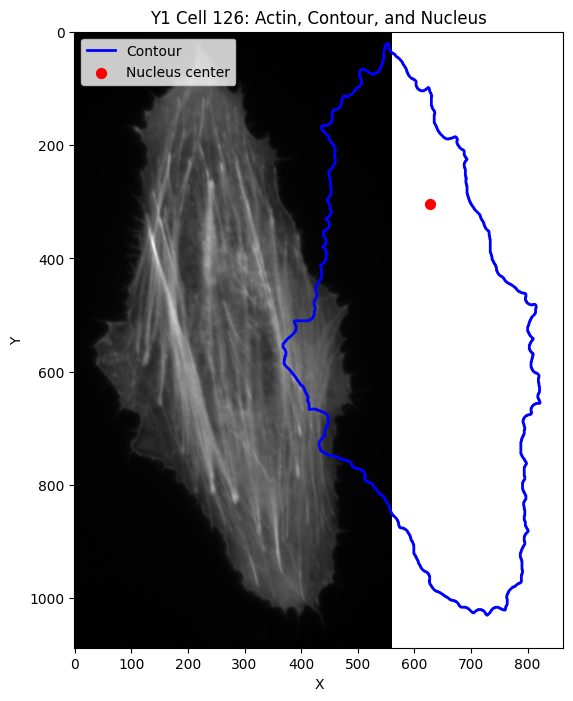

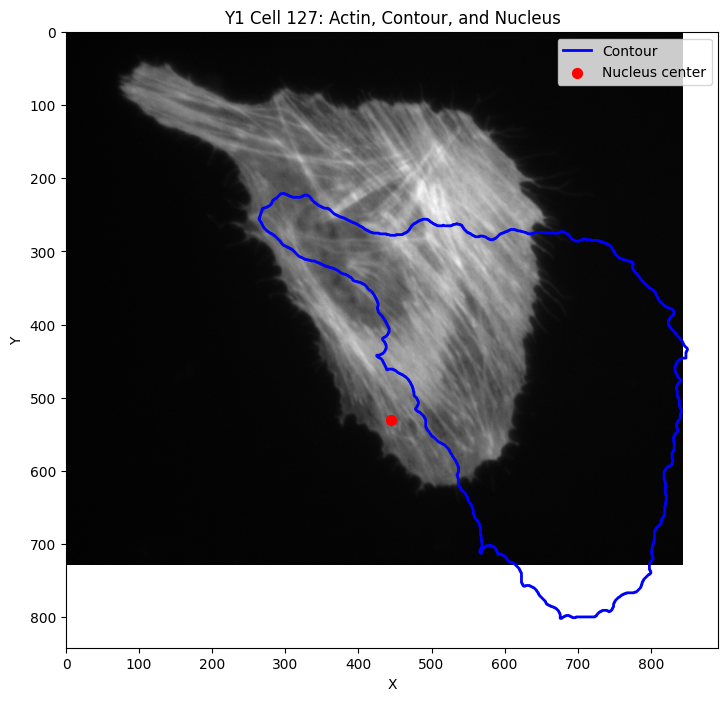

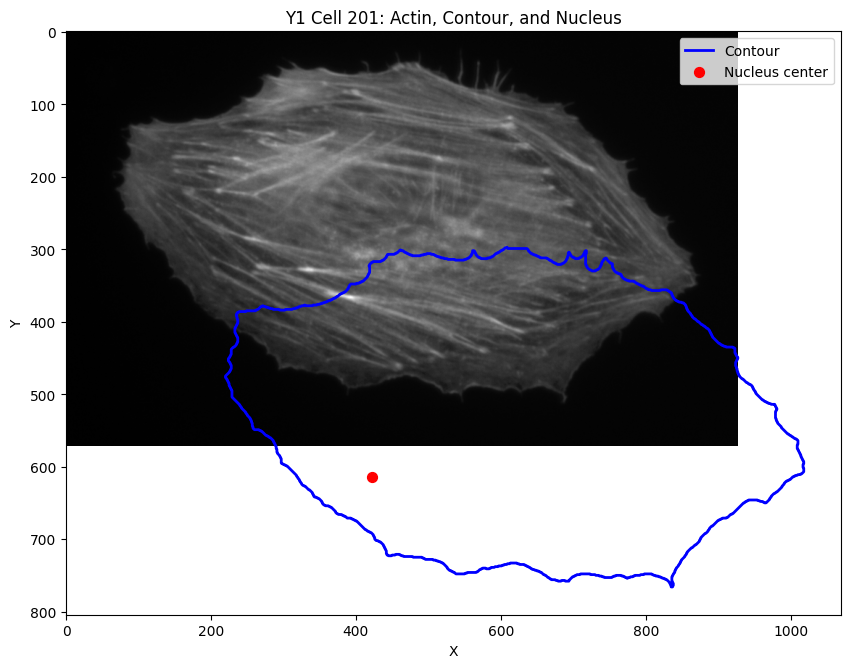

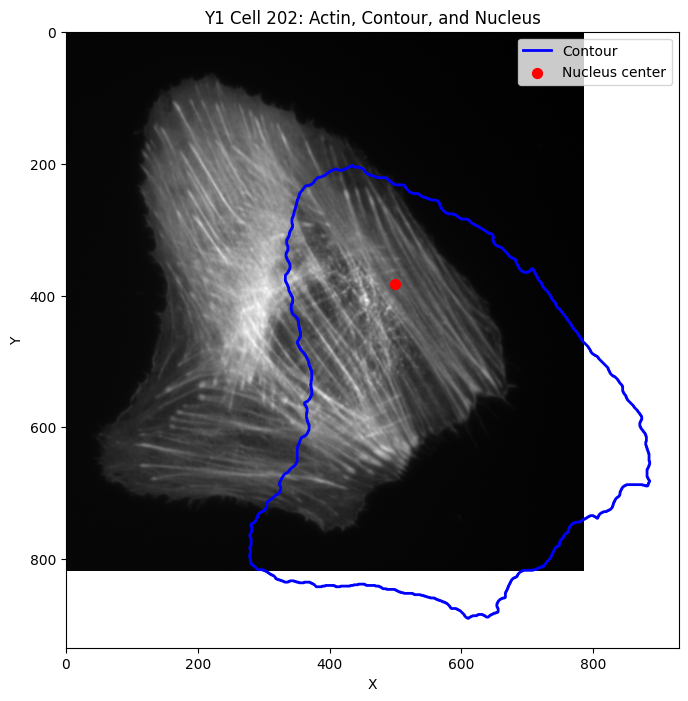

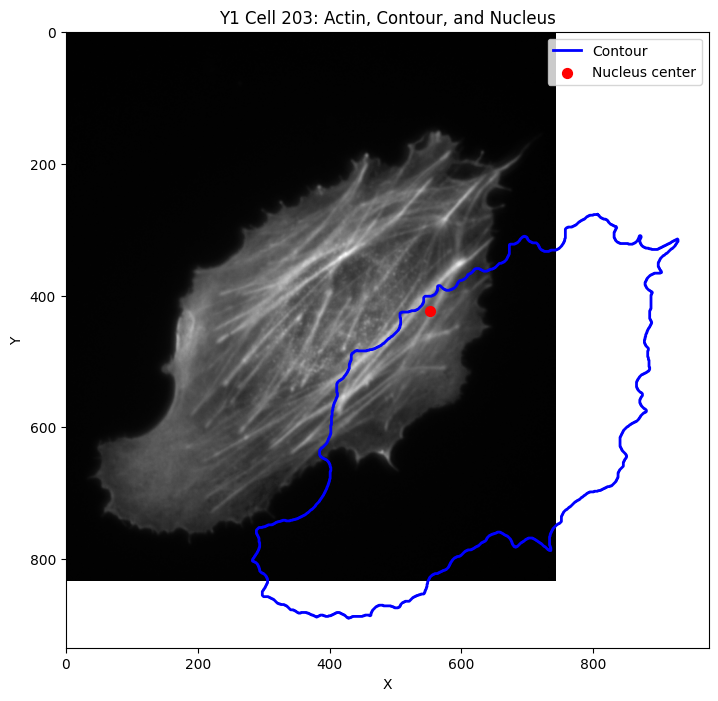

[578012:578012:1216/152923.388238:ERROR:gpu/command_buffer/service/shared_image/shared_image_manager.cc:397] SharedImageManager::ProduceSkia: Trying to Produce a Skia representation from a non-existent mailbox.
[578012:578012:1216/152923.397272:ERROR:gpu/command_buffer/service/shared_image/shared_image_manager.cc:397] SharedImageManager::ProduceSkia: Trying to Produce a Skia representation from a non-existent mailbox.
[578012:578012:1216/152923.405817:ERROR:gpu/command_buffer/service/shared_image/shared_image_manager.cc:397] SharedImageManager::ProduceSkia: Trying to Produce a Skia representation from a non-existent mailbox.
[578012:578012:1216/152924.318636:ERROR:gpu/command_buffer/service/shared_image/shared_image_manager.cc:397] SharedImageManager::ProduceSkia: Trying to Produce a Skia representation from a non-existent mailbox.
[578012:578012:1216/152924.327698:ERROR:gpu/command_buffer/service/shared_image/shared_image_manager.cc:397] SharedImageManager::ProduceSkia: Trying to Prod

In [ ]:
# Visualize first 5 cells
for i in cell_names_Y1[25:30]:
	contour = pandas.read_csv("../" + dataset_Y1 + "/cell/contours/" + str("%03d" % i) + "_contour.csv", header=None)
	actin = tifffile.imread("../" + dataset_Y1 + "/cell/raw_images/" + str("%03d" % i) + ".tif")
	center = pandas.DataFrame(
		[[centers_Y1.loc[i, "X"], centers_Y1.loc[i, "Y"] ]], 
		columns=["x", "y"]
	)
	
	fig_data = px.scatter(contour, x=0, y=1, width=800, height=600).data
	fig_data = fig_data + px.scatter(center, x="x", y="y").update_traces(marker={'size': 10, 'color': 'Red'}).data
	fig = go.Figure(fig_data)
	fig.update_layout(title=f"Y1 Cell {i:03d}", xaxis_title="X", yaxis_title="Y")
	fig.show()



## Y1: Compute Persistence Diagrams

Compute the persistence diagram for each HeLa cell using the radial function based at the nucleus center.


In [24]:
contours_Y1 = []
missing_files = []

for i in cell_names_Y1:
    image_path = "../" + dataset_Y1 + "/cell/raw_images/" + str("%03d" % i) + ".tif"
    if not os.path.exists(image_path):
        missing_files.append(i)
        print(f"Warning: image file {image_path} does not exist, skipping cell {i}")
        continue
    actin = tifffile.imread(image_path)
    height_diff = height_Y1 - actin.shape[0]
    width_diff = width_Y1 - actin.shape[1]
    focal_point = [
        (centers_Y1.loc[i, "X_m"] + width_diff/2),
        (centers_Y1.loc[i, "Y_m"] + height_diff/2)
    ]
    focal_points_Y1.append(focal_point)

    # Create polygon with focal point at nucleus center
    c_i = correa.create_polygon_focal_point(
        "../" + dataset_Y1 + "/cell/contours/" + str("%03d" % i) + "_contour.csv",
        [centers_Y1.loc[i, "X_m"] + width_diff/2, centers_Y1.loc[i, "Y_m"] + height_diff/2],
        convert_to_microns_factor=conversion_factor_Y1
    )
    c_i.persistence_diagram()
    contours_Y1.append(c_i)

    if (len(contours_Y1)) % 20 == 0:
        print(f"Processed {len(contours_Y1)}/{n_cells_Y1} cells")

print(f"Completed persistence diagrams for all {len(contours_Y1)} cells (skipped {len(missing_files)} missing files)")


Number of points loaded: 1960
focal is (527.828, 515.809).
Number of points before cleaning: 1960

Initial number of points in polygon      : 1960
Number of points in polygon after cleanup: 1037

build the polygon with 1037 points
shifting has occured, center was selected as (527.828, 515.809).
Number of points loaded: 2299
focal is (376.714, 534.363).
Number of points before cleaning: 2299

Initial number of points in polygon      : 2299
Number of points in polygon after cleanup: 1243

build the polygon with 1243 points
shifting has occured, center was selected as (376.714, 534.363).
Number of points loaded: 1209
focal is (663.73, 578.676).
Number of points before cleaning: 1209

Initial number of points in polygon      : 1209
Number of points in polygon after cleanup: 671

build the polygon with 671 points
shifting has occured, center was selected as (663.73, 578.676).
Number of points loaded: 1657
focal is (661.629, 535.76).
Number of points before cleaning: 1657

Initial number of 

In [26]:
focal_points_Y1_df = pandas.DataFrame(focal_points_Y1, columns=["X", "Y"], index=cell_names_Y1)
focal_points_Y1_df.to_csv("Y1_focal_points.csv")

## Y1: Compute Wasserstein Distances

Compute the Wasserstein distance between each pair of HeLa cells.


In [27]:
w_distances_Y1 = numpy.zeros((n_cells_Y1, n_cells_Y1))
for i in range(n_cells_Y1):
	for j in range(i, n_cells_Y1):
		dist_ij = correa.wasserstein_distance(contours_Y1[i], contours_Y1[j], q=2)
		dist_ji = correa.wasserstein_distance(contours_Y1[j], contours_Y1[i], q=2)
		dist = (dist_ij + dist_ji) / 2
		w_distances_Y1[i,j] = dist
		w_distances_Y1[j,i] = dist
	
	if (i+1) % 10 == 0:
		print(f"Computed distances for {i+1}/{n_cells_Y1} cells")

print(f"Completed Wasserstein distance computation for all {n_cells_Y1} cells")


Computed distances for 10/100 cells
Computed distances for 20/100 cells
Computed distances for 30/100 cells
Computed distances for 40/100 cells
Computed distances for 50/100 cells
Computed distances for 60/100 cells
Computed distances for 70/100 cells
Computed distances for 80/100 cells
Computed distances for 90/100 cells
Computed distances for 100/100 cells
Completed Wasserstein distance computation for all 100 cells


## Y1: Distance Heatmap

Display a heatmap of the Wasserstein distances for the Y1 dataset.


In [31]:
fig = px.imshow(w_distances_Y1, width=800, height=800)
fig.update_layout(title="Y1 Wasserstein Distance Heatmap")
fig.show()


Opening in existing browser session.


In [32]:
dists_Y1 = pandas.DataFrame(w_distances_Y1, columns=cell_names_Y1, index=cell_names_Y1)


## Y1: Hierarchical Clustering Analysis

Perform hierarchical clustering for the Y1 dataset with different linkage methods and numbers of clusters.


In [ ]:
A_Y1 = analysis(dists_Y1, [3,4,5], "Y1", "Y1")


## Y1: Compute purity scores based on ```average4```

In [ ]:
for k in range(4):
	clus = set(())
	for i in range(len(A_Y1[0]["average4"])):
		if A_Y1[0]["average4"].iloc[i] == str(k):
			clus.add(i)
	print(f"\nCluster {k}:")
	print(f"  Average linkage purity: {purity(A_Y1[6][0], clus, n_c)[1]:.4f}")
	print(f"  Complete linkage purity: {purity(A_Y1[6][1], clus, n_c)[1]:.4f}")
	print(f"  Single linkage purity: {purity(A_Y1[6][2], clus, n_c)[1]:.4f}")
	print(f"  Ward linkage purity: {purity(A_Y1[6][3], clus, n_c)[1]:.4f}")

# X1Y1 Combined Dataset Analysis

The X1Y1 combined dataset contains 240 cells (140 hMSC from X1 and 100 HeLa from Y1). This analysis will:
1. Combine the contours and persistence diagrams from both datasets
2. Compute Wasserstein distances between all pairs of cells across both types
3. Perform hierarchical clustering to see if the two cell types separate
4. Compare results with ground truth labels


## X1Y1: Combine Datasets

Combine the contours from X1 and Y1 datasets and create a combined cell name list.


In [29]:
# Combine contours from both datasets
contours_X1Y1 = contours_X1 + contours_Y1

# Create combined cell names with dataset prefix
cell_names_X1Y1 = [f"X1_{i:03d}" for i in cell_names_X1] + [f"Y1_{i:03d}" for i in cell_names_Y1]
n_cells_X1Y1 = len(cell_names_X1Y1)

print(f"Combined X1Y1 dataset contains {n_cells_X1Y1} cells")
print(f"  - X1 (hMSC): {n_cells_X1} cells")
print(f"  - Y1 (HeLa): {n_cells_Y1} cells")

# Create ground truth labels (1 for X1, 2 for Y1)
ground_truth_2clusters = [1] * n_cells_X1 + [2] * n_cells_Y1
print(f"\nGround truth: {n_cells_X1} cells in cluster 1 (X1), {n_cells_Y1} cells in cluster 2 (Y1)")


Combined X1Y1 dataset contains 240 cells
  - X1 (hMSC): 140 cells
  - Y1 (HeLa): 100 cells

Ground truth: 140 cells in cluster 1 (X1), 100 cells in cluster 2 (Y1)


## X1Y1: Compute Combined Distance Matrix

Compute the Wasserstein distance matrix for the combined dataset. We can reuse the within-dataset distances and only compute the cross-dataset distances.


In [30]:
# Initialize the combined distance matrix
w_distances_X1Y1 = numpy.zeros((n_cells_X1Y1, n_cells_X1Y1))

# Copy X1 within-dataset distances
w_distances_X1Y1[:n_cells_X1, :n_cells_X1] = w_distances_X1
print("Copied X1 within-dataset distances")

# Copy Y1 within-dataset distances
w_distances_X1Y1[n_cells_X1:, n_cells_X1:] = w_distances_Y1
print("Copied Y1 within-dataset distances")

# Compute cross-dataset distances (X1 vs Y1)
print("Computing cross-dataset distances (X1 vs Y1)...")
for i in range(n_cells_X1):
	for j in range(n_cells_Y1):
		dist_ij = correa.wasserstein_distance(contours_X1[i], contours_Y1[j], q=2)
		dist_ji = correa.wasserstein_distance(contours_Y1[j], contours_X1[i], q=2)
		dist = (dist_ij + dist_ji) / 2
		w_distances_X1Y1[i, n_cells_X1 + j] = dist
		w_distances_X1Y1[n_cells_X1 + j, i] = dist
	
	if (i+1) % 20 == 0:
		print(f"  Computed cross-distances for X1 cell {i+1}/{n_cells_X1}")

print(f"Completed combined distance matrix for all {n_cells_X1Y1} cells")


Copied X1 within-dataset distances
Copied Y1 within-dataset distances
Computing cross-dataset distances (X1 vs Y1)...
  Computed cross-distances for X1 cell 20/140
  Computed cross-distances for X1 cell 40/140
  Computed cross-distances for X1 cell 60/140
  Computed cross-distances for X1 cell 80/140
  Computed cross-distances for X1 cell 100/140
  Computed cross-distances for X1 cell 120/140
  Computed cross-distances for X1 cell 140/140
Completed combined distance matrix for all 240 cells


## X1Y1: Distance Heatmap

Display a heatmap of the combined distance matrix. The block structure should show lower distances within each cell type and higher distances between cell types.


In [ ]:
fig = px.imshow(w_distances_X1Y1, width=900, height=900)
fig.update_layout(
	title="X1Y1 Combined Wasserstein Distance Heatmap",
	xaxis_title="Cell Index",
	yaxis_title="Cell Index"
)
# Add annotations to show dataset boundaries
fig.add_vline(x=n_cells_X1-0.5, line_width=2, line_dash="dash", line_color="red")
fig.add_hline(y=n_cells_X1-0.5, line_width=2, line_dash="dash", line_color="red")
fig.show()


In [33]:
dists_X1Y1 = pandas.DataFrame(w_distances_X1Y1, columns=cell_names_X1Y1, index=cell_names_X1Y1)
dists_X1Y1.to_csv("X1Y1/X1Y1_distances.csv")


## X1Y1: Hierarchical Clustering Analysis

Perform hierarchical clustering on the combined dataset to see if the two cell types separate naturally.


In [ ]:
A_X1Y1 = analysis(dists_X1Y1, [2,3,4,5], "X1Y1", "X1Y1")


## X1Y1: Evaluate Clustering Quality

Peform the analysis.


In [ ]:
A_X1Y1 = analysis(dists_X1Y1, [2,3,4,5,6,7,8,9,10], "X1Y1", "X1Y1")


In [1]:
import pandas


In [5]:
distances = pandas.read_csv("X1Y1/X1Y1_distances.csv", index_col=0)
order = pandas.read_csv("/Users/yossi/PDaMSoC-data/CompareDistances/X1Y1_Distances/list_X1Y1", header=None, index_col=0)

In [7]:
order.index = [x[:-4] for x in order.index]

In [10]:
distances = distances.loc[order.index, order.index]
distances

,X1_106,X1_112,X1_072,X1_066,X1_099,X1_098,X1_067,X1_073,X1_113,X1_107,...,Y1_340,Y1_341,Y1_342,Y1_343,Y1_344,Y1_345,Y1_346,Y1_347,Y1_348,Y1_349
X1_106,0.000000,83.304708,160.910345,195.095073,87.872205,110.180881,81.488784,62.270554,77.129168,42.485743,...,40.305955,37.818173,30.706067,16.787770,23.941440,48.432851,17.111151,25.058679,43.261271,21.496382
X1_112,83.304708,0.000000,85.462907,154.513245,68.266993,43.636108,24.226446,47.250990,25.921769,58.064753,...,111.026759,78.204516,88.657568,97.149100,92.427652,77.668777,95.452820,86.383799,79.149809,90.209204
X1_072,160.910345,85.462907,0.000000,126.266684,107.154918,66.068622,90.315003,105.841977,92.834250,131.780887,...,170.913528,148.577630,162.078174,164.743122,163.284723,141.760864,166.564280,157.577541,143.305962,159.612225
X1_066,195.095073,154.513245,126.266684,0.000000,152.593635,127.929238,152.345045,168.983130,154.850519,175.870706,...,204.327347,187.156308,194.746130,197.722076,195.684220,179.000452,198.927673,191.458115,184.003220,192.727394
X1_099,87.872205,68.266993,107.154918,152.593635,0.000000,72.935881,58.472809,62.295530,68.148577,78.174424,...,87.492756,82.364184,97.186317,88.694054,92.503222,73.012908,90.878414,87.189500,76.800006,83.839659
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Y1_345,48.432851,77.668777,141.760864,179.000452,73.012908,95.864795,71.137815,54.727495,74.316192,45.793836,...,72.617310,20.375930,43.766585,54.033629,45.869868,0.000000,55.434892,34.630977,10.163015,40.812597
Y1_346,17.111151,95.452820,166.564280,198.927673,90.878414,121.892318,92.919980,73.384850,88.940538,52.218624,...,25.724853,41.457539,25.933057,14.369519,17.879190,55.434892,0.000000,25.326132,49.693773,24.025373
Y1_347,25.058679,86.383799,157.577541,191.458115,87.189500,110.733952,81.540449,60.521978,80.988617,45.711743,...,40.685596,20.212575,16.605854,26.416136,16.035367,34.630977,25.326132,0.000000,29.214113,18.229194
Y1_348,43.261271,79.149809,143.305962,184.003220,76.800006,98.323864,72.440054,55.696723,75.591681,40.801828,...,67.540266,14.967937,36.965311,50.076911,41.429879,10.163015,49.693773,29.214113,0.000000,37.936967


In [11]:
distances.to_csv("/Users/yossi/PDaMSoC-data/CompareDistances/X1Y1_Distances/distances_PH.dat", header=False, index=False)